# [RSNA 2023 Abdominal Trauma Detection](https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection)

> Detect and classify traumatic abdominal injuries

![](https://www.kaggle.com/competitions/52254/images/header)

# Idea:
* Same as [RSNA-ATD: CNN [TPU][Train]](https://www.kaggle.com/awsaf49/rsna-atd-cnn-tpu-train/) but with **2.5D** data.
* 2.5D method is simpling stacking different scan of same series to created a `RGB` like image but here each channel is associated with different scans.

# Notebooks
* 2.5D:
    * Train: [RSNA-ATD: 2.5D Series Image [Train]](https://www.kaggle.com/awsaf49/rsna-atd-2-5d-series-image-train)
    * Infer: [RSNA-ATD: 2.5D Series Image [Infer]](https://www.kaggle.com/awsaf49/rsna-atd-2-5d-series-image-infer)
* 2D:
    * Train: [RSNA-ATD: CNN [TPU][Train]](https://www.kaggle.com/awsaf49/rsna-atd-cnn-tpu-train/)
    * Infer: [RSNA-ATD: CNN [TPU][Infer]](https://www.kaggle.com/awsaf49/rsna-atd-cnn-tpu-infer/)

# Logging:

# Install Libraries

In [1]:
!pip install -q /kaggle/input/rsna-atd-whl-ds/python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /kaggle/input/rsna-atd-whl-ds/pylibjpeg-1.4.0-py3-none-any.whl
!cp -r /kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle /tmp/ && pip install -q /tmp/efficientnet_kaggle

# Import Libraries

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import yaml
import gc



from IPython import display as ipd
from glob import glob
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Version Check

In [3]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)
print('tfa:', tfa.__version__)

np: 1.23.5
pd: 2.0.3
sklearn: 1.2.2
tf: 2.12.0
tfa: 0.21.0


# Configuration

In [4]:
class CFG:
    debug         = False
    # device
    device = "GPU" # or "GPU"
    # seed for data-split, layer init, augs
    seed = 42
    # which folds of ckpt to use
    num_folds = 1
    # dicom to png size
    resize_dim = 512
    # size of training image
    img_size = [512, 512]
    # clip
    clip = False
    # lr-scheduler
    scheduler   = 'exp' # cosine
    # threshold
    thr = 0.50
    # target column
    target_col  = ["bowel_healthy", "bowel_injury", "extravasation_healthy",
                   "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

# Reproducibility

In [5]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# Device Configs
This notebook is compatible for **remote-tpu**, **local-tpu**, **multi-gpu** and **single-gpu**. Simple change to `device="TPU"` for **remote-tpu** and `device="TPU-1VM"` for **local-tpu** and finally, `device="GPU"` for single or multi-gpu.

In [6]:
if "TPU" in CFG.device:
    tpu = 'local' if CFG.device=='TPU-1VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        CFG.device = "GPU"
        
if CFG.device == "GPU"  or CFG.device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        CFG.device = "CPU"

if CFG.device == "GPU":
    print("Num GPUs Available: ", ngpu)
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using single GPU
Num GPUs Available:  1
REPLICAS: 1


# Meta Data

In [7]:
BASE_PATH = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
IMG_DIR = '/tmp/dataset/rsna-atd'
NUM_SLICES = 4 # how many dicom files to take per series (scans)

## Test Paths

In [8]:
test_df = pd.read_csv(f'{BASE_PATH}/test_series_meta.csv')
test_df['dicom_folder'] = BASE_PATH + '/' + 'test_images'\
                                    + '/' + test_df.patient_id.astype(str)\
                                    + '/' + test_df.series_id.astype(str)
test_folders = test_df.dicom_folder.tolist()

test_paths = []
for folder in tqdm(test_folders):
    paths = sorted(glob(os.path.join(folder, '*dcm')),
                   key=lambda x: int(x.split('/')[-1].split('.')[0]))
    NUM_DICOM = len(paths)
    if len(test_folders)>6: # private test; contains all dicom files/folders
        STRIDE = -(-NUM_DICOM // (NUM_SLICES + 4))
        test_paths += [paths[STRIDE:NUM_DICOM-3*STRIDE:STRIDE]]
    else: # we can't access all the test dicom files in public test
        test_paths += [paths]

test_df['dicom_paths'] = test_paths
test_df = test_df[test_df.dicom_paths.map(len)>0] # in public test not all folder contains dicom file

test_df['image_path'] = f'{IMG_DIR}/test_images'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.series_id.astype(str) +'.png'
# test_df = test_df.drop_duplicates()

test_df.head(2)

  0%|          | 0/6 [00:00<?, ?it/s]

,patient_id,series_id,aortic_hu,dicom_folder,dicom_paths,image_path
1,48843,62825,238.0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,/tmp/dataset/rsna-atd/test_images/48843/62825.png
2,50046,24574,149.0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,/tmp/dataset/rsna-atd/test_images/50046/24574.png


# Check If Data Exist?

In [9]:
tf.io.gfile.exists(test_df.dicom_paths.iloc[0][0])

True

## Test Ditribution

In [10]:
print('test_files:',test_df.shape[0])

test_files: 3


# DICOM to PNG

## Create Directory

In [11]:
!rm -r /tmp/Dataset/rsna-atd
# os.makedirs('/tmp/dataset/rsna-atd/train_images', exist_ok = True)
os.makedirs(f'{IMG_DIR}/test_images', exist_ok = True)

rm: cannot remove '/tmp/Dataset/rsna-atd': No such file or directory


## Dicom Utils

In [12]:
import cv2
import pydicom

def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    return pixel_array


def read_xray(path, fix_monochrome = True):
    dicom = pydicom.dcmread(path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    IMG_SIZE = [CFG.resize_dim, CFG.resize_dim]
    data = cv2.resize(data, IMG_SIZE, cv2.INTER_LINEAR)
    data = (data * 255).astype(np.uint8)
    return data

def load_scan(paths):
    IMG_SIZE = [CFG.resize_dim, CFG.resize_dim]
    img = np.empty(shape=(*IMG_SIZE, NUM_SLICES), dtype=np.uint8)
    for i, path in enumerate(paths):
        img[...,i] = read_xray(path)
    return img

def load_img(path):
    img = cv2.imread(path, -1)[...,::-1]
    return img
    
def resize_and_save(paths):
    img = load_scan(paths)
    file_path = paths[0]
    sub_path = file_path.split("/",4)[-1].split('.dcm')[0] + '.png'
    infos = sub_path.split('/')
    split = infos[-4]
    pid = infos[-3]
    sid = infos[-2]
    iid = infos[-1]; iid = iid.replace('.png','')
    new_path = os.path.join(IMG_DIR, split, pid, sid + '.png')
    os.makedirs(new_path.rsplit('/',1)[0], exist_ok=True)
    cv2.imwrite(new_path, img[...,::-1])
    del img; gc.collect()
    return 

def show_img(img):
    num_channels = img.shape[-1]
    fig, axes = plt.subplots(1, num_channels+1, figsize=(num_channels*5, 5))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i in range(num_channels):
        axes[i+1].imshow(img[:, :, i], cmap='gray')
        axes[i+1].set_title(f'Channel: {i:02d}')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

## Data Check

In [13]:
test_df.dicom_paths.iloc[0]

['/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/48843/62825/30.dcm']

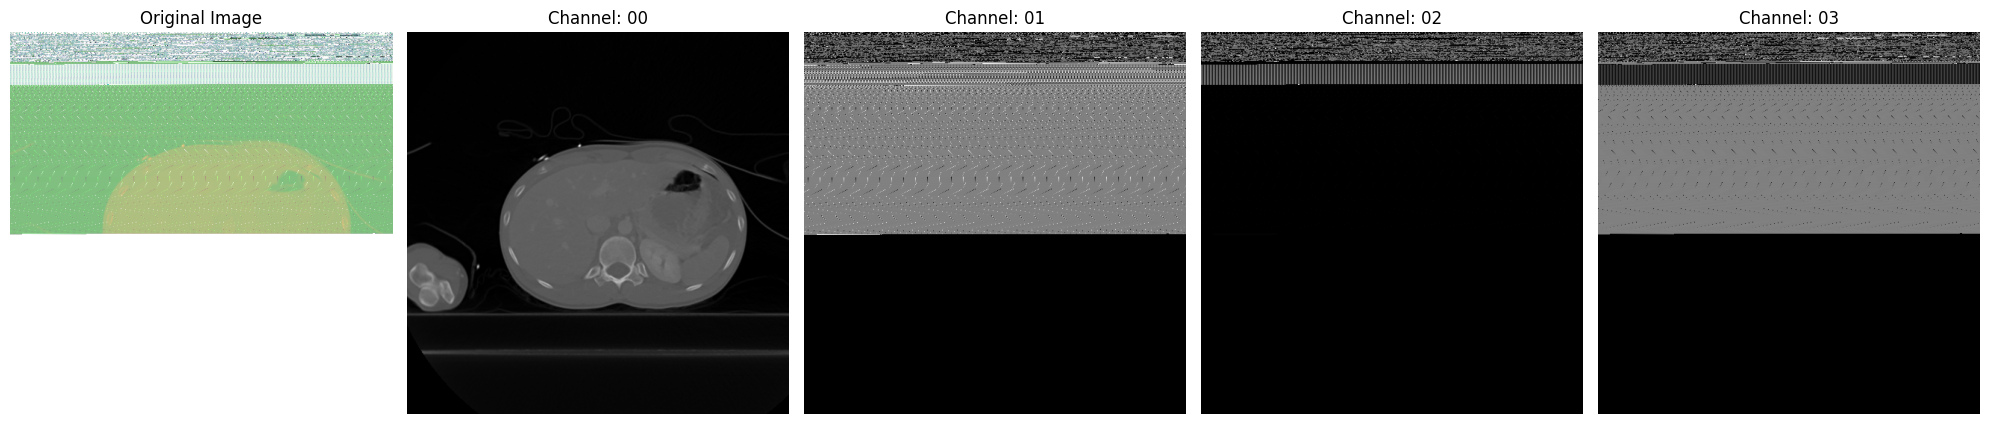

In [14]:
img = load_scan(test_df.dicom_paths.iloc[0])
show_img(img)

## Conversion

In [15]:
%%time
from joblib import Parallel, delayed
file_paths = test_df.dicom_paths.tolist()
_ = Parallel(n_jobs=-1,backend='loky')(delayed(resize_and_save)(file_path)\
                                                  for file_path in tqdm(file_paths))
del _; gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 309 ms, sys: 110 ms, total: 420 ms
Wall time: 2.1 s


12699

## Check Image

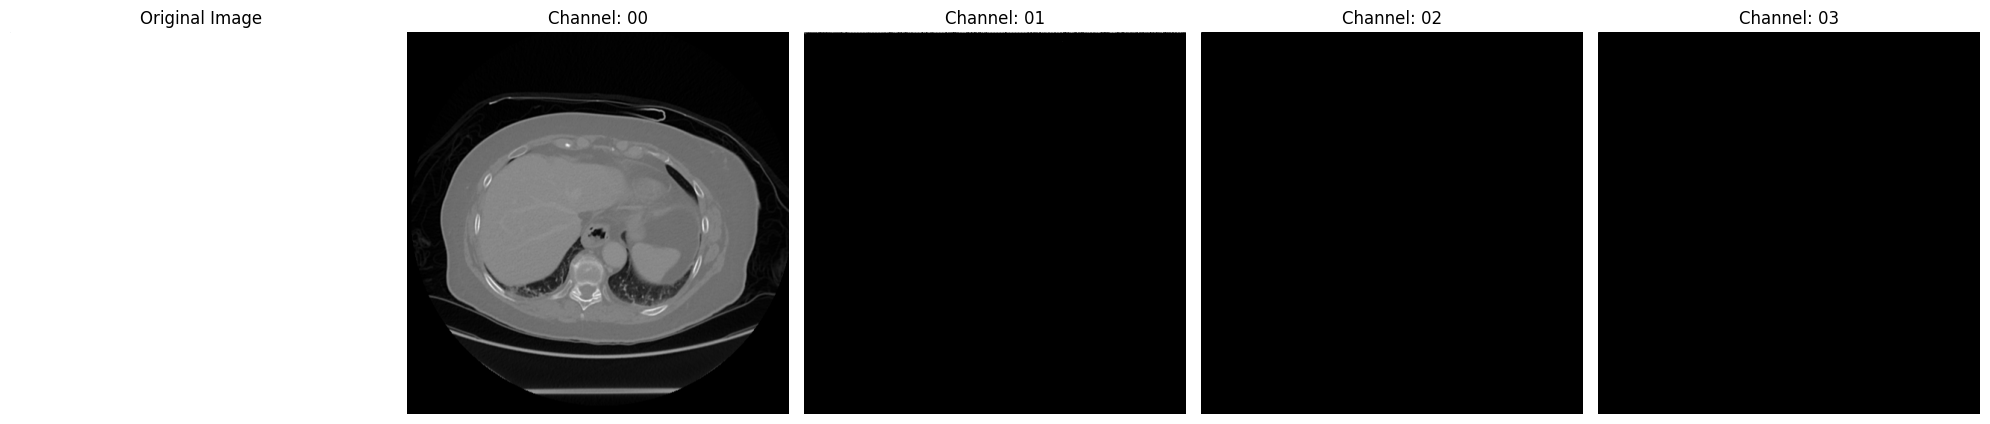

In [16]:
img = load_img(f'{IMG_DIR}/test_images/50046/24574.png')
show_img(img)

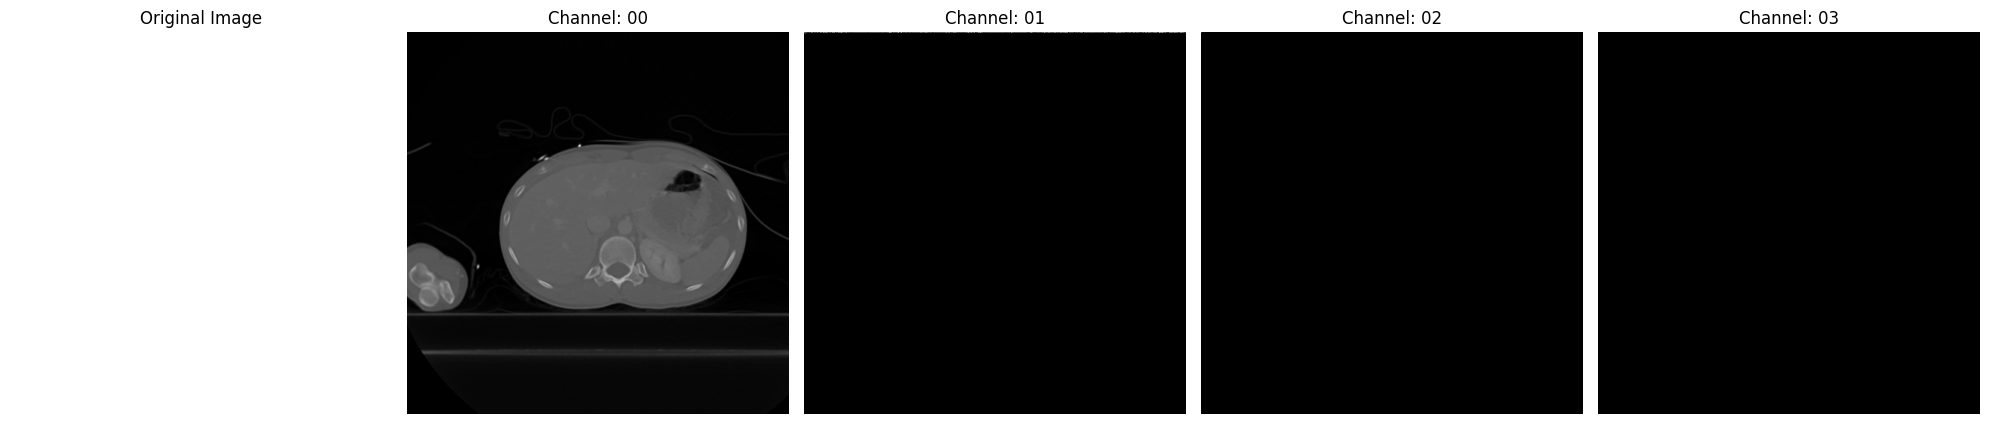

In [17]:
img = load_img(f'{IMG_DIR}/test_images/48843/62825.png')
show_img(img)

## Data Pipeline

In [18]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='png'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=4, dtype=tf.uint8)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*target_size, 4])

        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.cast(label, tf.float32)
    
    return decode_with_labels if with_labels else decode


def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Visualization

In [19]:
def display_batch(batch, size=2):
    if isinstance(batch, tuple):
        imgs, tars = batch
        tars = tf.concat(tars,axis=-1).numpy()
    else:
        imgs = batch
        tars = None
    
    plt.figure(figsize=(size*5, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        if tars is not None:
            plt.title(f'{tars[img_idx].round(2)}', fontsize=12)
        img = imgs[img_idx,]
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show() 

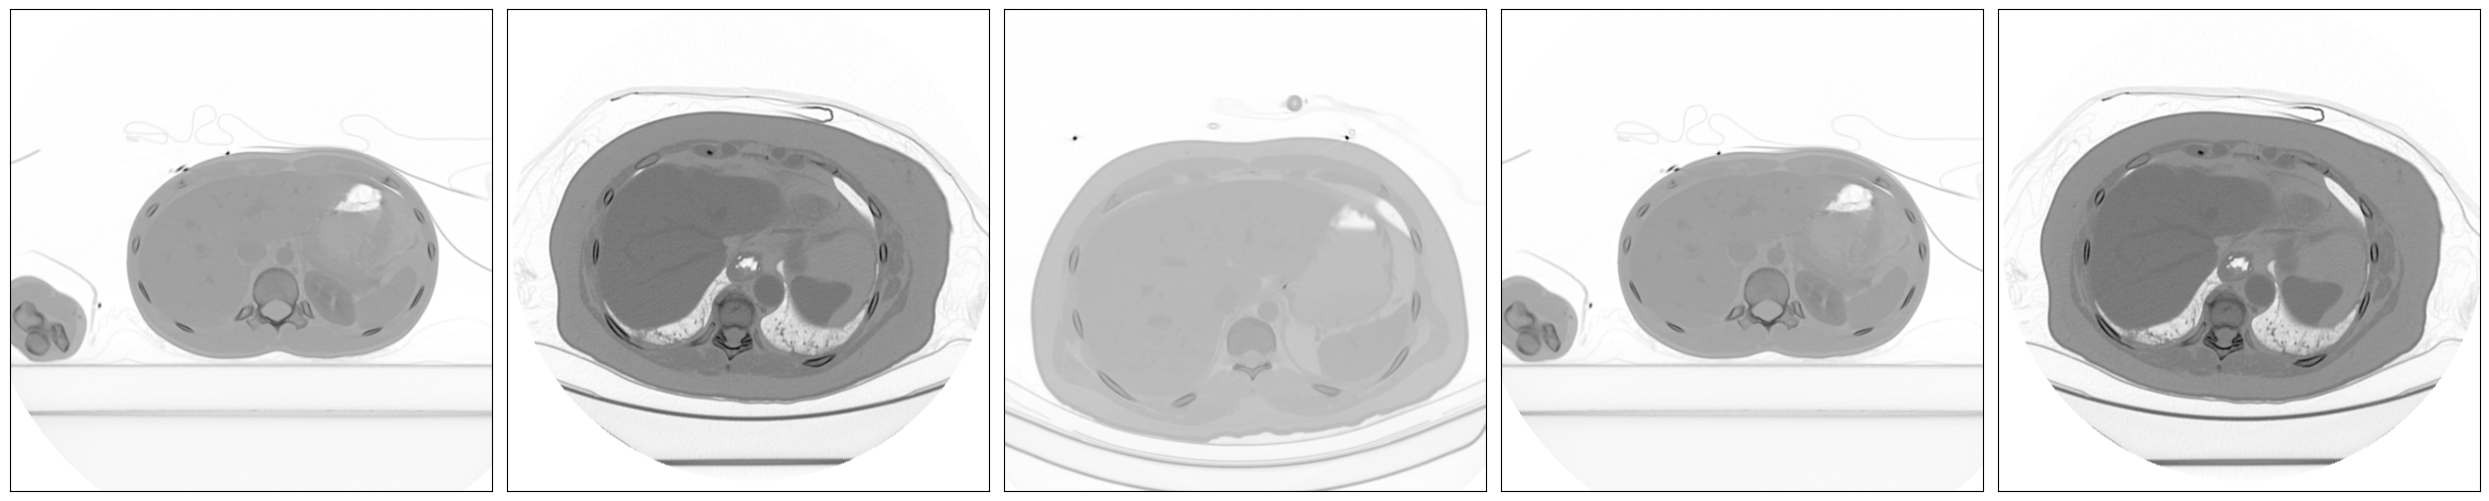

In [20]:
fold_df = test_df.copy()
paths  = fold_df.image_path.tolist()
labels = None
ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 5);

# Model Configs

In [21]:
CKPT_DIRS = [
    ([512, 512], '/kaggle/input/rsna-2023-2-5d-models'),
]

MODEL_CONFIGS = []
for img_size, ckpt_dir in  CKPT_DIRS:
    paths = sorted(glob(os.path.join(ckpt_dir, '*h5')))[0:CFG.num_folds]
    if len(paths)==0:
        print('no model found for :',base_dir)
    MODEL_CONFIGS.append([img_size, paths])
display(MODEL_CONFIGS)

[[[512, 512], ['/kaggle/input/rsna-2023-2-5d-models/fold-0.h5']]]

# Utility

In [22]:
def mc_proc(pred):
    argmax = np.argmax(pred, axis=1).astype('uint8')
    one_hot = tf.keras.utils.to_categorical(argmax, num_classes=3)
    return one_hot.astype('uint8')

def sc_proc(pred, thr=0.5):
    proc_pred = (pred > thr).astype('uint8')
    return proc_pred

def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2 + 2 + 3*3), dtype=np.uint8)

    # bowel, extravasation
    proc_pred[:, 0] = sc_proc(pred[:, 0])
    proc_pred[:, 1] = 1 - proc_pred[:, 0]
    proc_pred[:, 2] = sc_proc(pred[:, 1])
    proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = mc_proc(pred[:, 2:5])
    proc_pred[:, 7:10] = mc_proc(pred[:, 5:8])
    proc_pred[:, 10:13] = mc_proc(pred[:, 8:11])

    return proc_pred

def post_proc_v2(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype='float32')

    # bowel, extravasation
    proc_pred[:, 0] = 1 - pred[:, 0] # bowel-healthy
    proc_pred[:, 1] = pred[:, 0] # bowel-injured
    proc_pred[:, 2] = 1 - pred[:, 1] # extra-healthy
    proc_pred[:, 3] = pred[:, 1] # extra-injured
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred

# Inference

In [23]:
# Getting unique patient IDs from test dataset
patient_ids = test_df['patient_id'].unique()

# Initializing array to store predictions
patient_preds = np.zeros(shape=(len(patient_ids), 2*2 + 3*3), dtype='float32')

# Iterating over each patient
for pidx, patient_id in tqdm(enumerate(patient_ids), total=len(patient_ids), desc="Patients "):
    # Query the dataframe for a particular patient
    patient_df = test_df.loc[test_df["patient_id"] == patient_id]
    
    # Initializing model predictions array
    model_preds = np.zeros(shape=(1, 11), dtype=np.float32)
    
    print("="*25)
    print(f"   Patient ID: {patient_id}")
    print("="*25)
    
    # Iterating over each model
    for midx, (img_size, fold_paths) in enumerate(MODEL_CONFIGS):
        
        # Getting image paths for a patient
        patient_paths = patient_df.image_path.tolist()

        # Setting batch size based on number of patient paths and dimension of image
        dim = np.prod(img_size)**0.5
        CFG.batch_size = REPLICAS * int(32 * 2)
            
        # Clip batch_sizs to min
        min_bs = 2**np.floor(np.log2(len(patient_paths)))
        CFG.batch_size = min(min_bs, CFG.batch_size)

        # Building dataset for prediction
        dtest = build_dataset(
            patient_paths, 
            batch_size=CFG.batch_size, repeat=True, 
            shuffle=False, cache=False,
            decode_fn=build_decoder(with_labels=False, target_size=img_size),
        )
        
        # Iterating over each fold
        for fold_path in fold_paths:
            with strategy.scope():
                # Loading a model from a fold path
                model = tf.keras.models.load_model(fold_path, compile=False)
            
            # Predicting with the model
            pred = model.predict(dtest, steps = len(patient_paths) / CFG.batch_size, verbose=1)
            pred = np.concatenate(pred, axis=-1).astype('float32') # reducing memory footprint
            pred = pred[:len(patient_paths), :]
            pred = pred.reshape(len(patient_paths), 11)
            pred = np.max(pred, axis=0) # taking max prediction of all ct scans for a patient
            
            # Store model's prediction
            model_preds += pred / (len(fold_paths)*len(MODEL_CONFIGS))
            
            # Deleting variables to free up memory
            del model, pred; gc.collect()
            
            print('\n')
        
        del dtest, patient_paths; gc.collect()
            
    # Adding processed predictions to patient_preds
    patient_preds[pidx, :] += post_proc_v2(model_preds)[0]
    
    del model_preds; gc.collect()

print("Prediction Done!")

Patients :   0%|          | 0/3 [00:00<?, ?it/s]

   Patient ID: 48843
1/1 [==============================] - 8s 8s/step


   Patient ID: 50046
1/1 [==============================] - 2s 2s/step


   Patient ID: 63706
1/1 [==============================] - 2s 2s/step


Prediction Done!


# Submission

In [24]:
# Create Submission
pred_df = pd.DataFrame({'patient_id':patient_ids,})
pred_df[CFG.target_col] = patient_preds.astype('float32')

# Align with sample submission
sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[['patient_id']]
sub_df = sub_df.merge(pred_df, on='patient_id', how='left')

# Store submission
sub_df.to_csv('submission.csv',index=False)
sub_df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.733019,0.266981,0.688379,0.311621,0.540313,0.234292,0.225395,0.447849,0.351921,0.200229,0.553452,0.213597,0.232951
1,50046,0.944984,0.055016,0.909971,0.090029,0.828186,0.116909,0.054904,0.805234,0.148683,0.046083,0.732775,0.169619,0.097606
2,63706,0.889046,0.110954,0.857233,0.142767,0.680660,0.202065,0.117275,0.647249,0.232186,0.120565,0.650569,0.165208,0.184224
